**Binary Classification with a Deepl Learning Model**

In [2]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import TimeSeriesSplit, KFold
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical


In [3]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load lagged data

In [4]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [5]:
# convert index to datetime type
df.index = pd.to_datetime(df.index)
# drop wind speed to reduce multicollinearity
df.drop(['wind_speed_m/s', 'wind_speed_m/s_lag1', 'wind_speed_m/s_lag2', 'wind_speed_m/s_lag3'], inplace=True, axis=1)

Adding weekday and season cols

In [ ]:
'''
# Assuming df_lagged is your DataFrame with a datetime index
# Create a new column for weekday/weekend
df_lagged['weekday'] = df_lagged.index.weekday < 5

# Create a new column for season based on month
df_lagged['season'] = (df_lagged.index.month % 12 + 3) // 3

# Perform one-hot encoding for the 'season' column
df_lagged = pd.get_dummies(df_lagged, columns=['season'], drop_first=True)

# Perform one-hot encoding for the 'weekday' column
df_lagged = pd.get_dummies(df_lagged, columns=['weekday'], drop_first=True)

# Convert the 'weekday' and 'season' columns to numerical
df_lagged['weekday'] = df_lagged['weekday_True'].astype(int)
df_lagged['season'] = df_lagged[['season_2', 'season_3', 'season_4']].idxmax(axis=1).str.extract(r'(\d)').astype(int)

# Drop the intermediate columns created during one-hot encoding
df_lagged.drop(columns=['weekday_True', 'season_2', 'season_3', 'season_4'], inplace=True)

# Now df_lagged contains the original data with the new weekday and season columns encoded numerically
'''

Deep learning model with 3 hidden layers consisting of 100, 50 and 25 neurons

In [6]:
# get desired df size
start_date = '2022-01-01'
end_date = '2023-12-31'
df = df.loc[start_date:end_date]

In [7]:
# impute, scale pipeline and smote (for class imbalance)
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# define features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [8]:
# Define model architecture
def make_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(input_shape),
        #Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # add l2 regularization
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        #tf.keras.layers.Dropout(0.5), #add dropout layers to reduce overfitting
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model parameters
input_shape = X.shape[1:]
num_classes = 1  # binary classification

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

In [11]:
# cross-testidation
n_splits = 50 #500
test_size = 48 #(48 - 12h with 15 min intervals)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap = 10)

# Initialize lists to store etestuation metrics for each fold
f1_scores_train = []
precision_scores_train = []
f1_scores_test = []
precision_scores_test = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Training on fold {fold}/{n_splits}")

    # Get the data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # preprocess train data
    X_train_balanced = preprocessor.fit_transform(X_train_fold)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_balanced, y_train_fold)

    # Define validation and train data for this fold (but test seperate to keep it the same as other models)
    val_split = int(len(X_train_fold) * 0.2)  # Adjust validation split as needed
    X_val_fold, y_val_fold = X_train_fold[:val_split], y_train_fold[:val_split]
    X_train_fold, y_train_fold = X_train_fold[val_split:], y_train_fold[val_split:]

    # Create model instance
    model = make_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision()])

    # to address the class imbalance further
    class_weights = ...

    # Train the model
    with tf.device('/device:GPU:0'):
      model.fit(
          X_train_fold, y_train_fold,
          validation_data=(X_val_fold, y_val_fold),
          epochs=100,
          batch_size=500,
          #class_weight=class_weights,
          callbacks=callbacks,
          verbose=1
      )

    # preprocess testidation/test data
    X_test_fold = preprocessor.transform(X_test_fold)

    # Predict on the test set
    y_pred_test = model.predict(X_test_fold)
    y_pred_test_classes = (y_pred_test > 0.5).astype(int)
    f1_test = f1_score(y_test_fold, y_pred_test_classes)
    precision_test = precision_score(y_test_fold, y_pred_test_classes)

    if precision_test != 0 and f1_test != 0:
        precision_scores_test.append(precision_test)
        f1_scores_test.append(f1_test)
    else:
        continue

    # Predict on the train set
    y_pred_train = model.predict(X_train_fold)
    y_pred_train_classes = (y_pred_train > 0.5).astype(int)
    f1_train = f1_score(y_train_fold, y_pred_train_classes)
    precision_train = precision_score(y_train_fold, y_pred_train_classes)
    f1_scores_train.append(f1_train)
    precision_scores_train.append(precision_train)

    # Print etestuation metrics for fold
    print(f"Fold {fold} - Test F1 score: {f1_test}, Test Precision: {precision_test}")
    print(f"Fold {fold} - Train F1 score: {f1_train}, Train Precision: {precision_train}")

# Print average scores across all folds
print("Average F1 score (test):", np.mean(f1_scores_test))
print("Average Precision score (test):", np.mean(precision_scores_test))
print("Average F1 score (Train):", np.mean(f1_scores_train))
print("Average Precision score (Train):", np.mean(precision_scores_train))


Training on fold 1/50
Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 118.1387 - accuracy: 0.7730 - precision_7: 0.1618 - val_loss: 11.0445 - val_accuracy: 0.8634 - val_precision_7: 0.0218 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 40.0189 - accuracy: 0.7809 - precision_7: 0.1928 - val_loss: 14.7693 - val_accuracy: 0.9397 - val_precision_7: 0.0043 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 42.0509 - accuracy: 0.7855 - precision_7: 0.1972 - val_loss: 12.6697 - val_accuracy: 0.9391 - val_precision_7: 0.0126 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 46.5257 - accuracy: 0.7889 - precision_7: 0.2064 - val_loss: 134.6392 - val_accuracy: 0.4428 - val_precision_7: 0.0382 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 57.1776 - accuracy: 0.7873 - precision_7: 0.2155 - val_loss: 27.9500 - val_ac

2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on fold 2/50
Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 285.1668 - accuracy: 0.7510 - precision_8: 0.1466 - val_loss: 57.5443 - val_accuracy: 0.8898 - val_precision_8: 0.0162 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 82.4272 - accuracy: 0.7582 - precision_8: 0.1657 - val_loss: 33.1272 - val_accuracy: 0.9630 - val_precision_8: 0.0000e+00 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 5ms/step - loss: 81.2329 - accuracy: 0.7648 - precision_8: 0.1818 - val_loss: 108.6396 - val_accuracy: 0.4055 - val_precision_8: 0.0340 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 62.2980 - accuracy: 0.7697 - precision_8: 0.1868 - val_loss: 13.4291 - val_accuracy: 0.9415 - val_precision_8: 0.0135 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 1s 5ms/step - loss: 61.9862 - accuracy: 0.7782 - precision_8: 0.2040 - val_loss: 52.3848 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 263.9955 - accuracy: 0.7626 - precision_9: 0.1652 - val_loss: 21.3589 - val_accuracy: 0.8683 - val_precision_9: 0.0272 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 1s 5ms/step - loss: 137.8444 - accuracy: 0.7717 - precision_9: 0.1813 - val_loss: 96.2683 - val_accuracy: 0.7076 - val_precision_9: 0.0461 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 107.7871 - accuracy: 0.7815 - precision_9: 0.2011 - val_loss: 68.3690 - val_accuracy: 0.9402 - val_precision_9: 0.0292 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 77.8728 - accuracy: 0.7879 - precision_9: 0.2083 - val_loss: 137.4582 - val_accuracy: 0.5773 - val_precision_9: 0.0409 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 103.0985 - accuracy: 0.7871 - precision_9: 0.2133 - val_loss: 71.7494 - val_accuracy: 0.9034 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 176.2368 - accuracy: 0.7689 - precision_10: 0.1783 - val_loss: 125.9419 - val_accuracy: 0.5500 - val_precision_10: 0.0407 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 78.9819 - accuracy: 0.7786 - precision_10: 0.1964 - val_loss: 28.3726 - val_accuracy: 0.8936 - val_precision_10: 0.0117 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 45.8990 - accuracy: 0.7846 - precision_10: 0.2086 - val_loss: 16.6945 - val_accuracy: 0.9477 - val_precision_10: 0.0056 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 59.2299 - accuracy: 0.7875 - precision_10: 0.2025 - val_loss: 10.6802 - val_accuracy: 0.8460 - val_precision_10: 0.0216 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 43.1039 - accuracy: 0.7876 - precision_10: 0.2091 - val_loss: 12.9164 - val_accuracy: 0.779

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 206.7224 - accuracy: 0.7496 - precision_11: 0.1432 - val_loss: 64.8891 - val_accuracy: 0.9106 - val_precision_11: 0.0023 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 144.5238 - accuracy: 0.7605 - precision_11: 0.1699 - val_loss: 14.3163 - val_accuracy: 0.8940 - val_precision_11: 0.0170 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 99.3470 - accuracy: 0.7678 - precision_11: 0.1772 - val_loss: 51.1705 - val_accuracy: 0.2962 - val_precision_11: 0.0219 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 79.7314 - accuracy: 0.7569 - precision_11: 0.1763 - val_loss: 33.5048 - val_accuracy: 0.7375 - val_precision_11: 0.0354 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 72.6943 - accuracy: 0.7723 - precision_11: 0.1964 - val_loss: 25.8944 - val_accuracy: 0.938

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 302.8452 - accuracy: 0.7625 - precision_12: 0.1696 - val_loss: 29.3990 - val_accuracy: 0.8765 - val_precision_12: 0.0273 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 197.6496 - accuracy: 0.7652 - precision_12: 0.1782 - val_loss: 62.4761 - val_accuracy: 0.9671 - val_precision_12: 0.0000e+00 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 119.5359 - accuracy: 0.7733 - precision_12: 0.1999 - val_loss: 64.8475 - val_accuracy: 0.7100 - val_precision_12: 0.0403 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 171.1139 - accuracy: 0.7738 - precision_12: 0.1973 - val_loss: 173.5480 - val_accuracy: 0.3593 - val_precision_12: 0.0269 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 131.7531 - accuracy: 0.7728 - precision_12: 0.1987 - val_loss: 13.8955 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 99.8484 - accuracy: 0.7554 - precision_13: 0.1617 - val_loss: 21.4076 - val_accuracy: 0.9579 - val_precision_13: 0.0180 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 57.8189 - accuracy: 0.7654 - precision_13: 0.1732 - val_loss: 7.6507 - val_accuracy: 0.9347 - val_precision_13: 0.0147 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 53.9461 - accuracy: 0.7748 - precision_13: 0.1915 - val_loss: 67.9740 - val_accuracy: 0.9701 - val_precision_13: 0.0000e+00 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 82.4211 - accuracy: 0.7714 - precision_13: 0.1825 - val_loss: 17.4729 - val_accuracy: 0.9574 - val_precision_13: 0.0132 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 41.8584 - accuracy: 0.7856 - precision_13: 0.1938 - val_loss: 21.0562 - val_accuracy: 0.96

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 971.8188 - accuracy: 0.7316 - precision_14: 0.1432 - val_loss: 9.2554 - val_accuracy: 0.8727 - val_precision_14: 0.0176 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 44.0362 - accuracy: 0.7633 - precision_14: 0.1652 - val_loss: 20.5284 - val_accuracy: 0.9667 - val_precision_14: 0.0103 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 34.2477 - accuracy: 0.7721 - precision_14: 0.1819 - val_loss: 11.2622 - val_accuracy: 0.8152 - val_precision_14: 0.0313 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 37.9608 - accuracy: 0.7779 - precision_14: 0.1905 - val_loss: 9.6276 - val_accuracy: 0.9454 - val_precision_14: 0.0102 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 41.2836 - accuracy: 0.7789 - precision_14: 0.1976 - val_loss: 10.6581 - val_accuracy: 0.8725 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 266.3378 - accuracy: 0.7437 - precision_15: 0.1513 - val_loss: 22.3289 - val_accuracy: 0.9499 - val_precision_15: 0.0208 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 130.7816 - accuracy: 0.7664 - precision_15: 0.1768 - val_loss: 56.3423 - val_accuracy: 0.9698 - val_precision_15: 0.0000e+00 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 149.2258 - accuracy: 0.7663 - precision_15: 0.1792 - val_loss: 23.3430 - val_accuracy: 0.9607 - val_precision_15: 0.0111 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 127.8721 - accuracy: 0.7712 - precision_15: 0.1957 - val_loss: 113.8027 - val_accuracy: 0.9726 - val_precision_15: 0.0000e+00 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 90.3222 - accuracy: 0.7783 - precision_15: 0.2135 - val_loss: 49.8013 - val_accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 1282.0422 - accuracy: 0.7142 - precision_16: 0.1457 - val_loss: 31.1809 - val_accuracy: 0.7878 - val_precision_16: 0.0460 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 72.5887 - accuracy: 0.7676 - precision_16: 0.1662 - val_loss: 95.3582 - val_accuracy: 0.4815 - val_precision_16: 0.0346 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 67.4134 - accuracy: 0.7760 - precision_16: 0.1740 - val_loss: 36.5264 - val_accuracy: 0.9586 - val_precision_16: 0.0048 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 69.1450 - accuracy: 0.7766 - precision_16: 0.1863 - val_loss: 12.8142 - val_accuracy: 0.9258 - val_precision_16: 0.0030 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 82.8081 - accuracy: 0.7795 - precision_16: 0.1869 - val_loss: 24.4889 - val_accuracy: 0.964

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
109/109 [==============================] - 2s 6ms/step - loss: 129.3984 - accuracy: 0.7571 - precision_17: 0.1615 - val_loss: 33.0273 - val_accuracy: 0.9708 - val_precision_17: 0.0238 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 0s 5ms/step - loss: 64.5815 - accuracy: 0.7735 - precision_17: 0.1944 - val_loss: 18.9253 - val_accuracy: 0.9324 - val_precision_17: 0.0285 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 1s 5ms/step - loss: 56.9485 - accuracy: 0.7738 - precision_17: 0.2010 - val_loss: 35.2818 - val_accuracy: 0.7469 - val_precision_17: 0.0399 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 1s 5ms/step - loss: 53.9988 - accuracy: 0.7729 - precision_17: 0.1996 - val_loss: 16.8464 - val_accuracy: 0.7582 - val_precision_17: 0.0215 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 1s 5ms/step - loss: 54.9269 - accuracy: 0.7794 - precision_17: 0.1997 - val_loss: 19.8231 - val_accuracy: 0.7562

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 7ms/step - loss: 303.3073 - accuracy: 0.7607 - precision_18: 0.1685 - val_loss: 53.5185 - val_accuracy: 0.8906 - val_precision_18: 0.0052 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 110.8468 - accuracy: 0.7702 - precision_18: 0.1857 - val_loss: 20.2142 - val_accuracy: 0.9441 - val_precision_18: 0.0073 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 109.7654 - accuracy: 0.7679 - precision_18: 0.1883 - val_loss: 19.5648 - val_accuracy: 0.9629 - val_precision_18: 0.0067 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 144.8818 - accuracy: 0.7731 - precision_18: 0.1874 - val_loss: 139.9777 - val_accuracy: 0.5080 - val_precision_18: 0.0136 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 99.4030 - accuracy: 0.7674 - precision_18: 0.1671 - val_loss: 24.7449 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 3s 6ms/step - loss: 551.5737 - accuracy: 0.7458 - precision_19: 0.1625 - val_loss: 272.7510 - val_accuracy: 0.3473 - val_precision_19: 0.0328 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 96.4186 - accuracy: 0.7640 - precision_19: 0.1763 - val_loss: 16.9627 - val_accuracy: 0.8685 - val_precision_19: 0.0075 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 54.2182 - accuracy: 0.7767 - precision_19: 0.1898 - val_loss: 14.3344 - val_accuracy: 0.6603 - val_precision_19: 0.0255 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 80.0313 - accuracy: 0.7678 - precision_19: 0.1798 - val_loss: 73.2509 - val_accuracy: 0.9523 - val_precision_19: 0.0000e+00 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 70.3172 - accuracy: 0.7804 - precision_19: 0.1979 - val_loss: 16.7743 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 143.0939 - accuracy: 0.7641 - precision_20: 0.1696 - val_loss: 25.4373 - val_accuracy: 0.9650 - val_precision_20: 0.0082 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 89.0070 - accuracy: 0.7712 - precision_20: 0.1869 - val_loss: 23.3326 - val_accuracy: 0.9697 - val_precision_20: 0.0175 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 78.0805 - accuracy: 0.7781 - precision_20: 0.1994 - val_loss: 186.9362 - val_accuracy: 0.4099 - val_precision_20: 0.0361 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 83.3787 - accuracy: 0.7760 - precision_20: 0.2020 - val_loss: 53.2409 - val_accuracy: 0.9211 - val_precision_20: 0.0264 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 5ms/step - loss: 74.6218 - accuracy: 0.7763 - precision_20: 0.2022 - val_loss: 21.2884 - val_accuracy: 0.894

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 255.8870 - accuracy: 0.7590 - precision_21: 0.1625 - val_loss: 32.5726 - val_accuracy: 0.5330 - val_precision_21: 0.0161 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 123.4909 - accuracy: 0.7641 - precision_21: 0.1807 - val_loss: 34.7054 - val_accuracy: 0.7887 - val_precision_21: 0.0212 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 89.1674 - accuracy: 0.7687 - precision_21: 0.1924 - val_loss: 43.0375 - val_accuracy: 0.5133 - val_precision_21: 0.0295 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 74.0024 - accuracy: 0.7750 - precision_21: 0.2094 - val_loss: 32.8220 - val_accuracy: 0.9678 - val_precision_21: 0.0119 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 88.5945 - accuracy: 0.7752 - precision_21: 0.2046 - val_loss: 26.1785 - val_accuracy: 0.854

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 213.6325 - accuracy: 0.7621 - precision_22: 0.1638 - val_loss: 23.7188 - val_accuracy: 0.9313 - val_precision_22: 0.0051 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 102.2815 - accuracy: 0.7741 - precision_22: 0.1843 - val_loss: 28.5939 - val_accuracy: 0.8965 - val_precision_22: 0.0182 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 91.3537 - accuracy: 0.7815 - precision_22: 0.1905 - val_loss: 72.7218 - val_accuracy: 0.4484 - val_precision_22: 0.0358 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 65.0662 - accuracy: 0.7844 - precision_22: 0.2075 - val_loss: 24.2011 - val_accuracy: 0.8493 - val_precision_22: 0.0251 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 89.0763 - accuracy: 0.7803 - precision_22: 0.2012 - val_loss: 18.9065 - val_accuracy: 0.908

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 7ms/step - loss: 108.2331 - accuracy: 0.7656 - precision_23: 0.1620 - val_loss: 42.8258 - val_accuracy: 0.7049 - val_precision_23: 0.0161 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 66.4570 - accuracy: 0.7695 - precision_23: 0.1903 - val_loss: 27.3958 - val_accuracy: 0.9541 - val_precision_23: 0.0037 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 58.1215 - accuracy: 0.7793 - precision_23: 0.2023 - val_loss: 7.5264 - val_accuracy: 0.8253 - val_precision_23: 0.0235 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 42.9968 - accuracy: 0.7848 - precision_23: 0.2142 - val_loss: 32.0039 - val_accuracy: 0.9507 - val_precision_23: 0.0031 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 45.6582 - accuracy: 0.7819 - precision_23: 0.2128 - val_loss: 18.6042 - val_accuracy: 0.6443 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 789.5082 - accuracy: 0.7562 - precision_24: 0.1597 - val_loss: 29.6637 - val_accuracy: 0.8986 - val_precision_24: 0.0295 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 67.7812 - accuracy: 0.7835 - precision_24: 0.1889 - val_loss: 28.0317 - val_accuracy: 0.9506 - val_precision_24: 0.0156 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 76.4611 - accuracy: 0.7893 - precision_24: 0.1980 - val_loss: 42.7172 - val_accuracy: 0.9643 - val_precision_24: 0.0233 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 71.4581 - accuracy: 0.7918 - precision_24: 0.2106 - val_loss: 45.4948 - val_accuracy: 0.9269 - val_precision_24: 0.0296 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 64.2219 - accuracy: 0.7919 - precision_24: 0.2046 - val_loss: 125.0893 - val_accuracy: 0.584

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 349.3000 - accuracy: 0.7674 - precision_25: 0.1681 - val_loss: 49.7625 - val_accuracy: 0.9463 - val_precision_25: 0.0187 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 78.9660 - accuracy: 0.7825 - precision_25: 0.1968 - val_loss: 13.6526 - val_accuracy: 0.8551 - val_precision_25: 0.0276 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 63.9551 - accuracy: 0.7886 - precision_25: 0.2043 - val_loss: 9.3283 - val_accuracy: 0.7353 - val_precision_25: 0.0273 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 71.5806 - accuracy: 0.7880 - precision_25: 0.2150 - val_loss: 9.4899 - val_accuracy: 0.9521 - val_precision_25: 0.0301 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 70.7191 - accuracy: 0.7927 - precision_25: 0.2162 - val_loss: 15.6351 - val_accuracy: 0.9141 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 228.2723 - accuracy: 0.7645 - precision_26: 0.1651 - val_loss: 29.0749 - val_accuracy: 0.9424 - val_precision_26: 0.0049 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 148.0138 - accuracy: 0.7705 - precision_26: 0.1854 - val_loss: 156.1860 - val_accuracy: 0.6312 - val_precision_26: 0.0494 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 124.2837 - accuracy: 0.7780 - precision_26: 0.1967 - val_loss: 72.1650 - val_accuracy: 0.7130 - val_precision_26: 0.0156 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 85.6900 - accuracy: 0.7770 - precision_26: 0.2022 - val_loss: 25.9385 - val_accuracy: 0.8206 - val_precision_26: 0.0239 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 97.1404 - accuracy: 0.7806 - precision_26: 0.2084 - val_loss: 346.1258 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 269.3947 - accuracy: 0.7488 - precision_27: 0.1532 - val_loss: 14.2902 - val_accuracy: 0.9293 - val_precision_27: 0.0051 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 93.7067 - accuracy: 0.7647 - precision_27: 0.1707 - val_loss: 34.5808 - val_accuracy: 0.9431 - val_precision_27: 0.0050 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 69.1381 - accuracy: 0.7767 - precision_27: 0.1948 - val_loss: 11.6571 - val_accuracy: 0.7425 - val_precision_27: 0.0242 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 74.5938 - accuracy: 0.7759 - precision_27: 0.1937 - val_loss: 77.1393 - val_accuracy: 0.5315 - val_precision_27: 0.0388 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 54.4001 - accuracy: 0.7856 - precision_27: 0.2121 - val_loss: 12.5325 - val_accuracy: 0.6219

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 425.9639 - accuracy: 0.7591 - precision_28: 0.1505 - val_loss: 8.0110 - val_accuracy: 0.8507 - val_precision_28: 0.0305 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 77.9375 - accuracy: 0.7843 - precision_28: 0.1800 - val_loss: 201.0308 - val_accuracy: 0.4904 - val_precision_28: 0.0429 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 90.7579 - accuracy: 0.7905 - precision_28: 0.2013 - val_loss: 30.9200 - val_accuracy: 0.9233 - val_precision_28: 0.0295 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 81.0203 - accuracy: 0.7913 - precision_28: 0.2067 - val_loss: 21.0060 - val_accuracy: 0.9219 - val_precision_28: 0.0326 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 90.7493 - accuracy: 0.7928 - precision_28: 0.2062 - val_loss: 26.0439 - val_accuracy: 0.8822

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 7ms/step - loss: 196.7486 - accuracy: 0.7534 - precision_29: 0.1579 - val_loss: 22.6807 - val_accuracy: 0.8473 - val_precision_29: 0.0108 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 59.0918 - accuracy: 0.7728 - precision_29: 0.1816 - val_loss: 15.6676 - val_accuracy: 0.9524 - val_precision_29: 0.0144 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 5ms/step - loss: 44.8980 - accuracy: 0.7824 - precision_29: 0.1973 - val_loss: 8.7385 - val_accuracy: 0.8266 - val_precision_29: 0.0265 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 45.2941 - accuracy: 0.7833 - precision_29: 0.2014 - val_loss: 30.3401 - val_accuracy: 0.6086 - val_precision_29: 0.0457 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 50.3755 - accuracy: 0.7808 - precision_29: 0.2021 - val_loss: 13.4768 - val_accuracy: 0.8524 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 232.6567 - accuracy: 0.7563 - precision_30: 0.1481 - val_loss: 136.4931 - val_accuracy: 0.9707 - val_precision_30: 0.0000e+00 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 120.0402 - accuracy: 0.7741 - precision_30: 0.1748 - val_loss: 16.4125 - val_accuracy: 0.8601 - val_precision_30: 0.0322 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 74.4127 - accuracy: 0.7810 - precision_30: 0.1953 - val_loss: 15.5535 - val_accuracy: 0.8542 - val_precision_30: 0.0291 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 62.6848 - accuracy: 0.7854 - precision_30: 0.2049 - val_loss: 29.1947 - val_accuracy: 0.9409 - val_precision_30: 0.0046 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 60.2347 - accuracy: 0.7900 - precision_30: 0.2134 - val_loss: 32.1575 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 294.8786 - accuracy: 0.7626 - precision_31: 0.1518 - val_loss: 36.2367 - val_accuracy: 0.7536 - val_precision_31: 0.0167 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 136.8342 - accuracy: 0.7640 - precision_31: 0.1643 - val_loss: 26.4297 - val_accuracy: 0.6840 - val_precision_31: 0.0109 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 108.5842 - accuracy: 0.7628 - precision_31: 0.1756 - val_loss: 119.1129 - val_accuracy: 0.5401 - val_precision_31: 0.0411 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 126.4869 - accuracy: 0.7685 - precision_31: 0.1840 - val_loss: 90.9625 - val_accuracy: 0.9688 - val_precision_31: 0.0000e+00 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 81.4912 - accuracy: 0.7705 - precision_31: 0.1847 - val_loss: 17.9427 - val_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 3s 6ms/step - loss: 135.5631 - accuracy: 0.7552 - precision_32: 0.1570 - val_loss: 23.2535 - val_accuracy: 0.9608 - val_precision_32: 0.0125 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 53.5643 - accuracy: 0.7727 - precision_32: 0.1728 - val_loss: 21.6268 - val_accuracy: 0.9643 - val_precision_32: 0.0263 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 90.4141 - accuracy: 0.7688 - precision_32: 0.1682 - val_loss: 92.3401 - val_accuracy: 0.3502 - val_precision_32: 0.0346 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 40.5336 - accuracy: 0.7841 - precision_32: 0.1837 - val_loss: 30.8852 - val_accuracy: 0.9626 - val_precision_32: 0.0147 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 37.3935 - accuracy: 0.7867 - precision_32: 0.1922 - val_loss: 22.7918 - val_accuracy: 0.9624

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 343.3031 - accuracy: 0.7483 - precision_33: 0.1313 - val_loss: 22.3847 - val_accuracy: 0.8512 - val_precision_33: 0.0185 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 56.2115 - accuracy: 0.7746 - precision_33: 0.1802 - val_loss: 18.6743 - val_accuracy: 0.9314 - val_precision_33: 0.0053 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 34.8668 - accuracy: 0.7855 - precision_33: 0.1992 - val_loss: 10.0856 - val_accuracy: 0.9176 - val_precision_33: 0.0204 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 54.9283 - accuracy: 0.7930 - precision_33: 0.2121 - val_loss: 13.5877 - val_accuracy: 0.8461 - val_precision_33: 0.0303 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 29.7334 - accuracy: 0.7924 - precision_33: 0.2175 - val_loss: 13.0142 - val_accuracy: 0.9192

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 192.5220 - accuracy: 0.7657 - precision_34: 0.1619 - val_loss: 23.4368 - val_accuracy: 0.9409 - val_precision_34: 0.0243 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 1s 5ms/step - loss: 95.0483 - accuracy: 0.7707 - precision_34: 0.1808 - val_loss: 114.9060 - val_accuracy: 0.8160 - val_precision_34: 0.0153 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 92.1985 - accuracy: 0.7785 - precision_34: 0.1973 - val_loss: 28.8305 - val_accuracy: 0.8362 - val_precision_34: 0.0185 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 67.0121 - accuracy: 0.7853 - precision_34: 0.2089 - val_loss: 29.0698 - val_accuracy: 0.9573 - val_precision_34: 0.0000e+00 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 1s 4ms/step - loss: 58.4593 - accuracy: 0.7878 - precision_34: 0.2031 - val_loss: 37.1569 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 7ms/step - loss: 365.9545 - accuracy: 0.7674 - precision_35: 0.1529 - val_loss: 124.8433 - val_accuracy: 0.5171 - val_precision_35: 0.0402 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 1s 5ms/step - loss: 63.3579 - accuracy: 0.7857 - precision_35: 0.1771 - val_loss: 49.4269 - val_accuracy: 0.9157 - val_precision_35: 0.0101 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 1s 5ms/step - loss: 66.0689 - accuracy: 0.7943 - precision_35: 0.2019 - val_loss: 18.3832 - val_accuracy: 0.9298 - val_precision_35: 0.0133 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 1s 5ms/step - loss: 48.6873 - accuracy: 0.7908 - precision_35: 0.2068 - val_loss: 24.2815 - val_accuracy: 0.7314 - val_precision_35: 0.0427 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 1s 5ms/step - loss: 112.8513 - accuracy: 0.7904 - precision_35: 0.2046 - val_loss: 24.5629 - val_accuracy: 0.83

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 256.8104 - accuracy: 0.7528 - precision_36: 0.1649 - val_loss: 68.8486 - val_accuracy: 0.9699 - val_precision_36: 0.0000e+00 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 111.7288 - accuracy: 0.7654 - precision_36: 0.1807 - val_loss: 112.8184 - val_accuracy: 0.9713 - val_precision_36: 0.0000e+00 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 127.4781 - accuracy: 0.7688 - precision_36: 0.1772 - val_loss: 127.3596 - val_accuracy: 0.9706 - val_precision_36: 0.0000e+00 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 128.4028 - accuracy: 0.7714 - precision_36: 0.1792 - val_loss: 33.6947 - val_accuracy: 0.9604 - val_precision_36: 0.0000e+00 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 112.3718 - accuracy: 0.7755 - precision_36: 0.1768 - val_loss: 16.9154 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 166.6242 - accuracy: 0.7701 - precision_37: 0.1742 - val_loss: 24.3844 - val_accuracy: 0.8759 - val_precision_37: 0.0225 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 57.9171 - accuracy: 0.7726 - precision_37: 0.1735 - val_loss: 34.2623 - val_accuracy: 0.6933 - val_precision_37: 0.0520 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 51.1200 - accuracy: 0.7788 - precision_37: 0.1893 - val_loss: 89.8193 - val_accuracy: 0.4443 - val_precision_37: 0.0396 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 72.2791 - accuracy: 0.7726 - precision_37: 0.1830 - val_loss: 8.7726 - val_accuracy: 0.8129 - val_precision_37: 0.0345 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 35.8680 - accuracy: 0.7866 - precision_37: 0.2073 - val_loss: 11.0930 - val_accuracy: 0.9048 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 186.4342 - accuracy: 0.7515 - precision_38: 0.1576 - val_loss: 34.0640 - val_accuracy: 0.9164 - val_precision_38: 0.0229 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 98.8748 - accuracy: 0.7665 - precision_38: 0.1724 - val_loss: 31.0565 - val_accuracy: 0.9184 - val_precision_38: 0.0464 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 1s 5ms/step - loss: 88.4623 - accuracy: 0.7714 - precision_38: 0.1858 - val_loss: 28.6117 - val_accuracy: 0.9529 - val_precision_38: 0.0157 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 99.2522 - accuracy: 0.7754 - precision_38: 0.1945 - val_loss: 32.4150 - val_accuracy: 0.6506 - val_precision_38: 0.0396 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 85.0314 - accuracy: 0.7777 - precision_38: 0.2015 - val_loss: 25.0016 - val_accuracy: 0.9144

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 7ms/step - loss: 488.1962 - accuracy: 0.7620 - precision_39: 0.1661 - val_loss: 58.0678 - val_accuracy: 0.9295 - val_precision_39: 0.0053 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 1s 5ms/step - loss: 108.7966 - accuracy: 0.7847 - precision_39: 0.1711 - val_loss: 8.1939 - val_accuracy: 0.9008 - val_precision_39: 0.0403 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 1s 5ms/step - loss: 51.3488 - accuracy: 0.7963 - precision_39: 0.1774 - val_loss: 40.4040 - val_accuracy: 0.9580 - val_precision_39: 0.0000e+00 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 1s 5ms/step - loss: 55.3807 - accuracy: 0.7972 - precision_39: 0.1743 - val_loss: 22.3927 - val_accuracy: 0.9242 - val_precision_39: 0.0047 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 1s 5ms/step - loss: 61.3634 - accuracy: 0.7971 - precision_39: 0.1858 - val_loss: 21.7319 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 150.8244 - accuracy: 0.7701 - precision_40: 0.1694 - val_loss: 31.5604 - val_accuracy: 0.7441 - val_precision_40: 0.0382 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 52.3160 - accuracy: 0.7764 - precision_40: 0.1877 - val_loss: 46.0717 - val_accuracy: 0.7109 - val_precision_40: 0.0396 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 55.8021 - accuracy: 0.7771 - precision_40: 0.1896 - val_loss: 14.7810 - val_accuracy: 0.9202 - val_precision_40: 0.0157 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 45.7839 - accuracy: 0.7808 - precision_40: 0.1982 - val_loss: 17.2042 - val_accuracy: 0.9437 - val_precision_40: 0.0163 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 39.9889 - accuracy: 0.7873 - precision_40: 0.2148 - val_loss: 15.1349 - val_accuracy: 0.9269

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 193.3002 - accuracy: 0.7631 - precision_41: 0.1521 - val_loss: 260.4630 - val_accuracy: 0.5815 - val_precision_41: 0.0488 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 86.2897 - accuracy: 0.7742 - precision_41: 0.1687 - val_loss: 48.0916 - val_accuracy: 0.7165 - val_precision_41: 0.0219 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 80.5837 - accuracy: 0.7783 - precision_41: 0.1807 - val_loss: 41.3504 - val_accuracy: 0.8535 - val_precision_41: 0.0255 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 1s 5ms/step - loss: 137.1802 - accuracy: 0.7739 - precision_41: 0.1778 - val_loss: 21.3173 - val_accuracy: 0.9387 - val_precision_41: 0.0047 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 54.3825 - accuracy: 0.7799 - precision_41: 0.1884 - val_loss: 32.2420 - val_accuracy: 0.95

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 348.4473 - accuracy: 0.7630 - precision_42: 0.1595 - val_loss: 26.6211 - val_accuracy: 0.9200 - val_precision_42: 0.0252 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 86.7104 - accuracy: 0.7759 - precision_42: 0.1858 - val_loss: 24.6342 - val_accuracy: 0.7167 - val_precision_42: 0.0200 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 127.8626 - accuracy: 0.7695 - precision_42: 0.1768 - val_loss: 104.5724 - val_accuracy: 0.9674 - val_precision_42: 0.0000e+00 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 82.5522 - accuracy: 0.7806 - precision_42: 0.1917 - val_loss: 58.9387 - val_accuracy: 0.6313 - val_precision_42: 0.0516 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 68.2306 - accuracy: 0.7830 - precision_42: 0.1947 - val_loss: 30.8370 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 131.0547 - accuracy: 0.7672 - precision_43: 0.1635 - val_loss: 131.8605 - val_accuracy: 0.5727 - val_precision_43: 0.0488 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 1s 5ms/step - loss: 58.3148 - accuracy: 0.7771 - precision_43: 0.1859 - val_loss: 23.4718 - val_accuracy: 0.6940 - val_precision_43: 0.0541 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 62.5792 - accuracy: 0.7801 - precision_43: 0.1971 - val_loss: 10.0160 - val_accuracy: 0.7950 - val_precision_43: 0.0344 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 47.4500 - accuracy: 0.7819 - precision_43: 0.1979 - val_loss: 12.2183 - val_accuracy: 0.9054 - val_precision_43: 0.0301 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 37.7547 - accuracy: 0.7833 - precision_43: 0.2025 - val_loss: 24.4012 - val_accuracy: 0.805

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
111/111 [==============================] - 2s 6ms/step - loss: 234.1429 - accuracy: 0.7727 - precision_44: 0.1495 - val_loss: 173.9420 - val_accuracy: 0.6351 - val_precision_44: 0.0536 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 73.6570 - accuracy: 0.7788 - precision_44: 0.1718 - val_loss: 64.4298 - val_accuracy: 0.6587 - val_precision_44: 0.0557 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 70.3328 - accuracy: 0.7834 - precision_44: 0.1869 - val_loss: 30.5515 - val_accuracy: 0.8215 - val_precision_44: 0.0157 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 56.8650 - accuracy: 0.7835 - precision_44: 0.1889 - val_loss: 20.6287 - val_accuracy: 0.9296 - val_precision_44: 0.0037 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 49.2323 - accuracy: 0.7909 - precision_44: 0.2062 - val_loss: 31.9748 - val_accuracy: 0.943

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 295.5178 - accuracy: 0.7599 - precision_45: 0.1539 - val_loss: 65.1364 - val_accuracy: 0.9215 - val_precision_45: 0.0031 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 96.1806 - accuracy: 0.7775 - precision_45: 0.1800 - val_loss: 44.5803 - val_accuracy: 0.9355 - val_precision_45: 0.0023 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 65.9756 - accuracy: 0.7889 - precision_45: 0.2019 - val_loss: 13.9810 - val_accuracy: 0.8900 - val_precision_45: 0.0240 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 1s 5ms/step - loss: 56.7655 - accuracy: 0.7870 - precision_45: 0.1970 - val_loss: 145.5652 - val_accuracy: 0.2845 - val_precision_45: 0.0405 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 5ms/step - loss: 59.0404 - accuracy: 0.7867 - precision_45: 0.2041 - val_loss: 16.7760 - val_accuracy: 0.935

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 7ms/step - loss: 414.3037 - accuracy: 0.7352 - precision_46: 0.1516 - val_loss: 38.1388 - val_accuracy: 0.6616 - val_precision_46: 0.0530 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 85.7742 - accuracy: 0.7689 - precision_46: 0.1707 - val_loss: 40.3820 - val_accuracy: 0.9622 - val_precision_46: 0.0161 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 66.3021 - accuracy: 0.7779 - precision_46: 0.1828 - val_loss: 23.0018 - val_accuracy: 0.9420 - val_precision_46: 0.0115 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 1s 4ms/step - loss: 65.0512 - accuracy: 0.7800 - precision_46: 0.1920 - val_loss: 27.6571 - val_accuracy: 0.9506 - val_precision_46: 0.0175 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 4ms/step - loss: 53.5942 - accuracy: 0.7862 - precision_46: 0.1988 - val_loss: 27.1895 - val_accuracy: 0.6415

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 3s 6ms/step - loss: 248.4238 - accuracy: 0.7540 - precision_47: 0.1585 - val_loss: 48.2322 - val_accuracy: 0.9501 - val_precision_47: 0.0174 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 82.6467 - accuracy: 0.7783 - precision_47: 0.1858 - val_loss: 18.8489 - val_accuracy: 0.6958 - val_precision_47: 0.0241 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 76.5027 - accuracy: 0.7729 - precision_47: 0.1779 - val_loss: 25.2631 - val_accuracy: 0.9538 - val_precision_47: 0.0170 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 1s 5ms/step - loss: 71.8681 - accuracy: 0.7824 - precision_47: 0.1931 - val_loss: 211.2842 - val_accuracy: 0.4771 - val_precision_47: 0.0490 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 96.3929 - accuracy: 0.7768 - precision_47: 0.1842 - val_loss: 42.3478 - val_accuracy: 0.775

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 235.7499 - accuracy: 0.7558 - precision_48: 0.1542 - val_loss: 77.0970 - val_accuracy: 0.9600 - val_precision_48: 0.0132 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 106.9346 - accuracy: 0.7778 - precision_48: 0.1840 - val_loss: 37.6444 - val_accuracy: 0.9570 - val_precision_48: 0.0000e+00 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 5ms/step - loss: 130.8811 - accuracy: 0.7803 - precision_48: 0.1868 - val_loss: 175.3410 - val_accuracy: 0.3249 - val_precision_48: 0.0419 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 90.2661 - accuracy: 0.7764 - precision_48: 0.1887 - val_loss: 18.6088 - val_accuracy: 0.8181 - val_precision_48: 0.0233 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 5ms/step - loss: 85.7036 - accuracy: 0.7779 - precision_48: 0.1901 - val_loss: 43.6132 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 7ms/step - loss: 98.1347 - accuracy: 0.7757 - precision_49: 0.1799 - val_loss: 20.2751 - val_accuracy: 0.9553 - val_precision_49: 0.0219 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 33.4860 - accuracy: 0.7861 - precision_49: 0.1939 - val_loss: 12.8384 - val_accuracy: 0.8005 - val_precision_49: 0.0346 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 4ms/step - loss: 35.7855 - accuracy: 0.7883 - precision_49: 0.1988 - val_loss: 12.0232 - val_accuracy: 0.9282 - val_precision_49: 0.0097 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 38.6794 - accuracy: 0.7955 - precision_49: 0.2136 - val_loss: 10.1734 - val_accuracy: 0.9361 - val_precision_49: 0.0284 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 24.7890 - accuracy: 0.7928 - precision_49: 0.2143 - val_loss: 6.9124 - val_accuracy: 0.9106 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 527.2299 - accuracy: 0.7557 - precision_50: 0.1462 - val_loss: 66.1692 - val_accuracy: 0.9495 - val_precision_50: 0.0000e+00 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 136.6611 - accuracy: 0.7738 - precision_50: 0.1682 - val_loss: 131.6811 - val_accuracy: 0.1977 - val_precision_50: 0.0392 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 4ms/step - loss: 86.5052 - accuracy: 0.7768 - precision_50: 0.1844 - val_loss: 27.6476 - val_accuracy: 0.7390 - val_precision_50: 0.0413 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 75.5563 - accuracy: 0.7796 - precision_50: 0.1916 - val_loss: 58.4486 - val_accuracy: 0.9371 - val_precision_50: 0.0026 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 78.1676 - accuracy: 0.7807 - precision_50: 0.1896 - val_loss: 14.6509 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 198.9172 - accuracy: 0.7719 - precision_51: 0.1646 - val_loss: 39.1626 - val_accuracy: 0.8941 - val_precision_51: 0.0227 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 136.4494 - accuracy: 0.7855 - precision_51: 0.1868 - val_loss: 43.9171 - val_accuracy: 0.6890 - val_precision_51: 0.0584 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 4ms/step - loss: 85.3176 - accuracy: 0.7907 - precision_51: 0.1872 - val_loss: 38.7641 - val_accuracy: 0.8928 - val_precision_51: 0.0251 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 1s 5ms/step - loss: 77.8696 - accuracy: 0.7917 - precision_51: 0.1951 - val_loss: 46.5700 - val_accuracy: 0.8779 - val_precision_51: 0.0300 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 75.2659 - accuracy: 0.7979 - precision_51: 0.2057 - val_loss: 15.1265 - val_accuracy: 0.854

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 796.7299 - accuracy: 0.7423 - precision_52: 0.1409 - val_loss: 24.5860 - val_accuracy: 0.9262 - val_precision_52: 0.0115 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 55.6467 - accuracy: 0.7707 - precision_52: 0.1624 - val_loss: 48.5954 - val_accuracy: 0.9603 - val_precision_52: 0.0000e+00 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 5ms/step - loss: 38.2982 - accuracy: 0.7825 - precision_52: 0.1895 - val_loss: 28.2741 - val_accuracy: 0.5353 - val_precision_52: 0.0560 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 1s 5ms/step - loss: 42.2778 - accuracy: 0.7810 - precision_52: 0.1865 - val_loss: 38.2239 - val_accuracy: 0.8315 - val_precision_52: 0.0388 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 4ms/step - loss: 67.2639 - accuracy: 0.7757 - precision_52: 0.1860 - val_loss: 15.1267 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 459.3661 - accuracy: 0.7610 - precision_53: 0.1506 - val_loss: 56.7040 - val_accuracy: 0.8740 - val_precision_53: 0.0173 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 74.9156 - accuracy: 0.7734 - precision_53: 0.1612 - val_loss: 35.6751 - val_accuracy: 0.9597 - val_precision_53: 0.0000e+00 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 4ms/step - loss: 80.0671 - accuracy: 0.7826 - precision_53: 0.1756 - val_loss: 77.5494 - val_accuracy: 0.6023 - val_precision_53: 0.0591 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 1s 4ms/step - loss: 69.4933 - accuracy: 0.7832 - precision_53: 0.1842 - val_loss: 23.5832 - val_accuracy: 0.7232 - val_precision_53: 0.0207 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 4ms/step - loss: 71.4977 - accuracy: 0.7745 - precision_53: 0.1747 - val_loss: 68.3746 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 99.8557 - accuracy: 0.7538 - precision_54: 0.1504 - val_loss: 11.9946 - val_accuracy: 0.9274 - val_precision_54: 0.0474 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 42.8548 - accuracy: 0.7777 - precision_54: 0.1688 - val_loss: 50.0685 - val_accuracy: 0.7080 - val_precision_54: 0.0287 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 42.1360 - accuracy: 0.7753 - precision_54: 0.1668 - val_loss: 12.0806 - val_accuracy: 0.8110 - val_precision_54: 0.0320 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 32.6805 - accuracy: 0.7828 - precision_54: 0.1842 - val_loss: 20.9456 - val_accuracy: 0.9518 - val_precision_54: 0.0000e+00 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 34.5720 - accuracy: 0.7841 - precision_54: 0.1833 - val_loss: 15.5381 - val_accuracy: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 6ms/step - loss: 245.0044 - accuracy: 0.7756 - precision_55: 0.1601 - val_loss: 16.9149 - val_accuracy: 0.8314 - val_precision_55: 0.0364 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 78.1189 - accuracy: 0.7832 - precision_55: 0.1802 - val_loss: 26.0444 - val_accuracy: 0.5340 - val_precision_55: 0.0498 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 87.3586 - accuracy: 0.7867 - precision_55: 0.1916 - val_loss: 17.0078 - val_accuracy: 0.7617 - val_precision_55: 0.0478 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 77.6474 - accuracy: 0.7859 - precision_55: 0.1887 - val_loss: 21.3005 - val_accuracy: 0.8543 - val_precision_55: 0.0261 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 4ms/step - loss: 104.4433 - accuracy: 0.7923 - precision_55: 0.2021 - val_loss: 33.8688 - val_accuracy: 0.928

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
112/112 [==============================] - 2s 7ms/step - loss: 152.3674 - accuracy: 0.7649 - precision_56: 0.1478 - val_loss: 33.9453 - val_accuracy: 0.8574 - val_precision_56: 0.0219 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 100.9188 - accuracy: 0.7781 - precision_56: 0.1622 - val_loss: 59.2897 - val_accuracy: 0.6393 - val_precision_56: 0.0195 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 1s 4ms/step - loss: 73.7469 - accuracy: 0.7801 - precision_56: 0.1757 - val_loss: 98.2371 - val_accuracy: 0.9516 - val_precision_56: 0.0000e+00 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 73.8268 - accuracy: 0.7820 - precision_56: 0.1820 - val_loss: 20.1906 - val_accuracy: 0.8558 - val_precision_56: 0.0314 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 1s 4ms/step - loss: 69.2603 - accuracy: 0.7882 - precision_56: 0.1905 - val_loss: 15.9836 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving the deep learning model

In [ ]:
# Save deep learning model
deep_learning_model.save('deep_learning_model.h5')

Trying a convolutional neural network for classification

In [ ]:
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-12-31 23:45:00')

# Filter rows that are outside of the specified timeframe
df_filtered = df_lagged[(df_lagged.index > end_date)]

df_filtered.head()

,redispatch,wind_direction_degrees,wind_direction_degrees_lag1,wind_direction_degrees_lag2,wind_direction_degrees_lag3,radiation_global_J/m2,radiation_global_J/m2_lag1,radiation_global_J/m2_lag2,radiation_global_J/m2_lag3,air_temperature_K,...,residual_load_MWh,residual_load_MWh_lag1,residual_load_MWh_lag2,residual_load_MWh_lag3,pumped_storage_MWh,pumped_storage_MWh_lag1,pumped_storage_MWh_lag2,pumped_storage_MWh_lag3,weekday,season
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0,270.0,270.0,270.0,270.0,0.0,0.0,0.0,0.0,282.05,...,212.98,215.08,223.97,230.88,39.98,50.40,46.20,47.45,0,2
2022-01-01 00:15:00,0.0,265.0,270.0,270.0,270.0,0.0,0.0,0.0,0.0,282.10,...,209.07,212.98,215.08,223.97,39.67,39.98,50.40,46.20,0,2
2022-01-01 00:30:00,0.0,270.0,265.0,270.0,270.0,0.0,0.0,0.0,0.0,282.35,...,208.60,209.07,212.98,215.08,43.30,39.67,39.98,50.40,0,2
2022-01-01 00:45:00,0.0,270.0,270.0,265.0,270.0,0.0,0.0,0.0,0.0,282.55,...,199.50,208.60,209.07,212.98,46.33,43.30,39.67,39.98,0,2
2022-01-01 01:00:00,0.0,270.0,270.0,270.0,265.0,0.0,0.0,0.0,0.0,282.65,...,194.30,199.50,208.60,209.07,39.12,46.33,43.30,39.67,0,2


In [ ]:
# Determine the cutoff point for splitting the data into train and test sets based on time
train_time = '2021-12-31'  # Define your train time
test_time_start = '2022-12-01'
test_time_end = '2023-01-01'

# Split the data into train and test sets based on time
train = df_filtered[(df_filtered.index > train_time) & (df_filtered.index < test_time_start)]
test = df_filtered[(df_filtered.index >= test_time_start) & (df_filtered.index < test_time_end)]

# Prepare the data
X_train = train.drop(columns=['redispatch'])  # Extract features
y_train = train['redispatch']  # Extract target

X_test = test.drop(columns=['redispatch'])  # Extract features
y_test = test['redispatch']  # Extract target

In [ ]:
# Normalize or scale the features if necessary
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the classes in the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

Using cross validation with CNN model

In [ ]:
# Reshape the input data to have a 3D shape
X_train_balanced_reshaped = np.expand_dims(X_train_balanced, axis=-1)
X_test_scaled_reshaped = np.expand_dims(X_test_scaled, axis=-1)

# Define the number of splits for time series cross-validation
n_splits = 5

# Define the TimeSeriesSplit cross-validation strategy
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define model architecture
def make_model(input_shape, num_classes):
    input_layer = Input(input_shape)

    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)

# Model parameters
input_shape = X_train_balanced_reshaped.shape[1:]
num_classes = len(np.unique(y_train_balanced))

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

# Initialize lists to store evaluation metrics for each fold
f1_scores = []
precision_scores = []
train_f1_scores = []
train_precision_scores = []
test_f1_scores = []
test_precision_scores = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_balanced_reshaped), 1):
    print(f"Training on fold {fold}/{n_splits}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X_train_balanced_reshaped[train_index], X_train_balanced_reshaped[test_index]
    y_train_fold, y_val_fold = y_train_balanced[train_index], y_train_balanced[test_index]

    # Create model instance
    model = make_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=500,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Predict on the validation set
    y_pred_val = model.predict(X_val_fold)
    y_pred_val_classes = np.argmax(y_pred_val, axis=1)

    # Calculate evaluation metrics for validation set
    f1 = f1_score(y_val_fold, y_pred_val_classes, average='macro')
    precision = precision_score(y_val_fold, y_pred_val_classes, average='macro')

    f1_scores.append(f1)
    precision_scores.append(precision)

    # Predict on the training set
    y_pred_train = model.predict(X_train_fold)
    y_pred_train_classes = np.argmax(y_pred_train, axis=1)

    # Calculate evaluation metrics for training set
    train_f1 = f1_score(y_train_fold, y_pred_train_classes, average='macro')
    train_precision = precision_score(y_train_fold, y_pred_train_classes, average='macro')

    train_f1_scores.append(train_f1)
    train_precision_scores.append(train_precision)

    # Predict on the test set
    y_pred_test = model.predict(X_test_scaled_reshaped)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)

    # Calculate evaluation metrics for test set
    test_f1 = f1_score(y_test, y_pred_test_classes, average='macro')
    test_precision = precision_score(y_test, y_pred_test_classes, average='macro')

    test_f1_scores.append(test_f1)
    test_precision_scores.append(test_precision)

# Print average scores across all folds
print("Average F1 score (validation):", np.mean(f1_scores))
print("Average precision score (validation):", np.mean(precision_scores))
print("Average F1 score (train):", np.mean(train_f1_scores))
print("Average precision score (train):", np.mean(train_precision_scores))
print("Average F1 score (test):", np.mean(test_f1_scores))
print("Average precision score (test):", np.mean(test_precision_scores))

Training on fold 1/5
Epoch 1/500
280/280 [==============================] - 6s 7ms/step - loss: 0.1080 - accuracy: 0.9729 - val_loss: 0.6433 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 2/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0575 - accuracy: 0.9860 - val_loss: 0.6115 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 3/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0508 - accuracy: 0.9860 - val_loss: 0.6887 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 4/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0469 - accuracy: 0.9862 - val_loss: 1.0179 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 5/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0416 - accuracy: 0.9865 - val_loss: 0.9479 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 6/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 0.7310 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 7/500
280/280 [======================

In [ ]:
#CNN result
#Average F1 score: 0.5076440234099121
#Average precision score: 0.6114438993430864

In [ ]:
# is it overfitting?
# Batchnormalization: method to make artificial NNs faster and more stable through re-centering and re-scaling layers inputs
# Dropout: regularisation technique for reducing overfitting in ANNs by preventing complex co-adaptations on training data. Performing model averaging


In [ ]:
'''
## safe
!mkdir -p saved_model
large_model.save('saved_model/my_large_model')

!zip -r saved_model.zip saved_model

# push to GitHub see [3]

## load
# unzip files
import zipfile
with zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Load the saved model
with tf.device('/device:GPU:0'):
    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')

# Check its architecture
new_large_model.summary()'''

"\n## safe \n!mkdir -p saved_model\nlarge_model.save('saved_model/my_large_model')\n\n!zip -r saved_model.zip saved_model\n\n# push to GitHub see [3]\n\n## load\n# unzip files \nimport zipfile\nwith zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:\n    zip_ref.extractall('./')\n\n# Load the saved model\nwith tf.device('/device:GPU:0'):\n    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')\n\n# Check its architecture\nnew_large_model.summary()"

Daily mean median and variance of redispatch

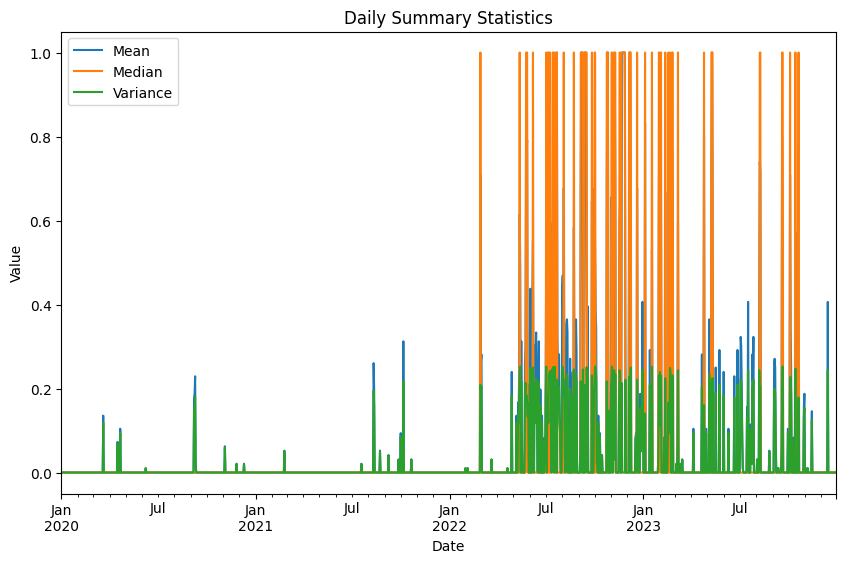

Autocorrelation: 0.960101247666363


In [ ]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
daily_summary = df['redispatch'].resample('D').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
daily_summary.plot(title='Daily Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Weekly mean median and variance of redispatch

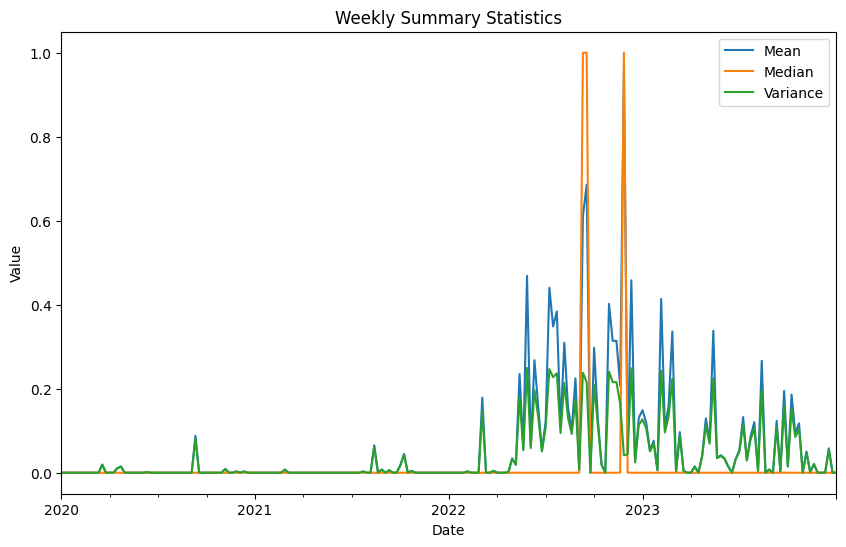

Autocorrelation: 0.960101247666363


In [ ]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
weekly_summary = df['redispatch'].resample('W').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
weekly_summary.plot(title='Weekly Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Monthly mean median and variance of redispatch

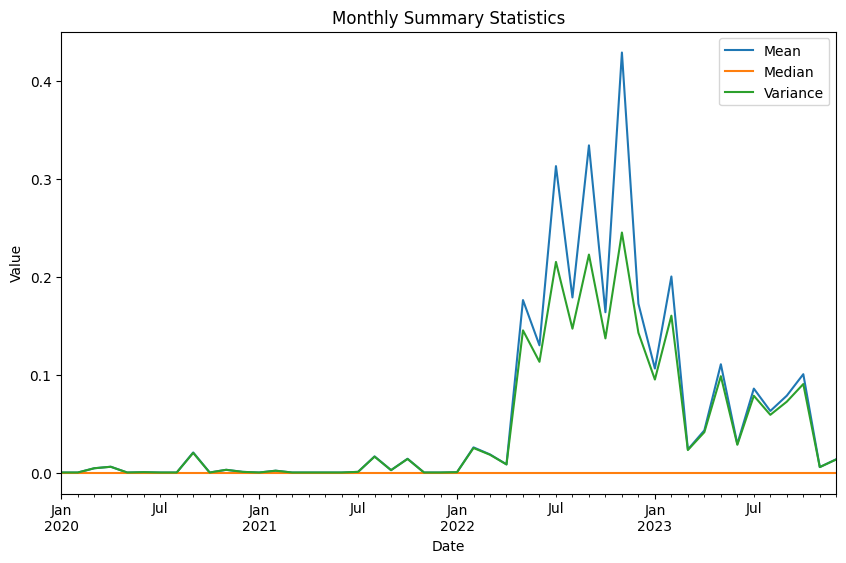

Autocorrelation: 0.960101247666363


In [ ]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
monthly_summary = df['redispatch'].resample('M').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
monthly_summary.plot(title='Monthly Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Checking for auto correlation of redispatch

<Figure size 1000x600 with 0 Axes>

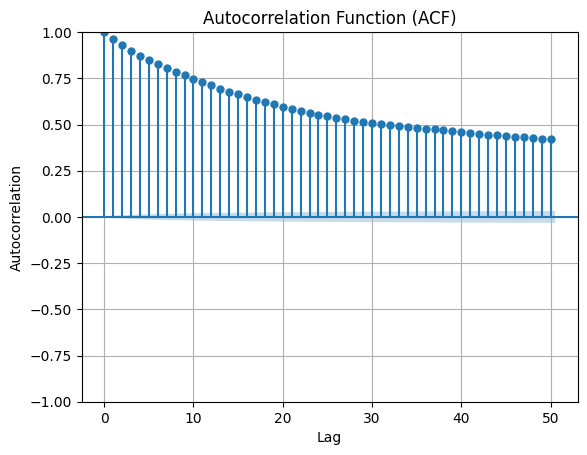

Autocorrelation: 0.960101247666363


In [ ]:
# Calculate autocorrelation function (ACF)
acf = pd.Series(data=df['redispatch']).autocorr()

# Plot autocorrelation function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(df['redispatch'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Autocorrelation:", acf)